## Домашняя работа №1 Part1
Вам предстоит:

Написать персептрон с двумя слоями. Реализовать форвард и бэквард пропогейшен



In [2]:
import numpy as np
from sklearn.metrics import classification_report
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import time

# Датасет
Загрузим Мнист. Почему именно он? Мы будем решать задачу бинарной классификации на паре цифр: 3 и 7. Плюсы в том, что примеров для этих чисел достаточно, чтобы обучить НС, у каждого примера не так много фичей (28Х28 - размерность картинок) и, в целом, эти классы хорошо отделяются. Я б с радостью показал вам пример с текстами, но если писать НС с нуля и пытаться обучаться на текстах, не факт, что у нас хоть что то обучится :(  
  

Торч - объект, который позволяет нормализовать картинки, можно думать о нем как о предобработке (регулярках) для текстов. В целом не стоит здесь долго думать

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [4]:
type(transform)

torchvision.transforms.transforms.Compose

Загружаем датасет. Возращается особенный торчовый класс, чуть ниже мы зададим его сами и научимся им пользоваться, пока оставляем эз из.


In [5]:
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 82780071.09it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 7338443.92it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 23321164.72it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 23007884.99it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Выбираем два класса. Если вы достаточно хорошо знакомы с пандас, то можно понять, что никакой магии здесь нет.

In [6]:
#фильтруем фичи (дата) по значению классификационных лэйблов (таргет), берем или цифру 3, или цифру 7
train_dataset.data = train_dataset.data[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
#тоже самое для тестового набора
test_dataset.data = test_dataset.data[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
test_dataset.targets = test_dataset.targets[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
#необходимы препроцессинг лейблов, видимо не все значения имеют тип integer, а нам нужен именно этот тип. функция лонг позволяет нам это сделать
#(self.long() is equivalent to self.to(torch.int64). See to())
train_dataset.targets = (train_dataset.targets == 7).long()
test_dataset.targets = (test_dataset.targets == 7).long()

Мы неоднократно говорили, что НС обычно тренируются бачами, в торче есть удобный класс, который позволяет обернуть наши датасеты в итерируемый объект. Если не знаете что такое итерируемый объект, погуглите :) можно думать об этом как о списке с составными элементами (элемент - батч - набор примеров)

In [28]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=True)

In [29]:
X, y = next(iter(train_loader)) #next(iter(x) - Возвращает следующий элемент итератора.
X

tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.424

In [30]:
y

tensor([1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1,
        0, 1, 1, 0, 0, 0, 0, 0])

Никакой магии, просто многомерные матрицы. Можно даже проверить, что то, что мы получили, то есть первый батч имеет правильную размерность. В y - 1 это класс цифры "7", 0 - "3"

In [31]:
X.shape #128 - примеров, [1, 28, 28] - размерность картинки, 1 - значит что из трех каналов (Р, Г, Б) у нас всего один, а сама картинка 28 на 28

torch.Size([128, 1, 28, 28])

In [32]:
y.shape

torch.Size([128])

Проверим, правда ли это картинки

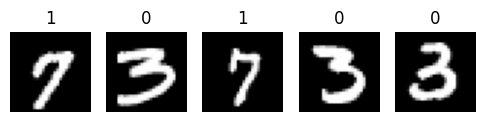

In [33]:
X, y = next(iter(train_loader))
X = X.numpy() # перевод тензора в массив нумпай, просто изменение типа данных
y = y.numpy()

plt.figure(figsize=(6, 7))
for i in range(5):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

Нам столько размерностей не нужно, поэтому давайте выпрямим матрицу, тем более, что мы знаем что значение каждого пикселя независимо друг друга.

In [34]:
X, y = next(iter(train_loader))

In [35]:
X = X.view(X.shape[0], -1)
X.shape

torch.Size([128, 784])

 Размерность
- количество примеров в батче
- количество фичей

In [36]:
y

tensor([0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0,
        1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
        0, 0, 0, 1, 1, 0, 0, 1])

Такой У нам не совсем подходит. Сейчас объясню почему. Размерность Х (128,784) матрично перемножим на скрытый слой (784,1) и получится (128,1). Нужно понимать, что размерность (128,) и (128,1) это немного разные вещи  

In [37]:
w = torch.rand(784, 1) #Рандомные необученые веса
pred = X.matmul(w)
print('y ', y.shape, '\nX ', X.shape, '\nw ', w.shape, '\npred', pred.shape)

y  torch.Size([128]) 
X  torch.Size([128, 784]) 
w  torch.Size([784, 1]) 
pred torch.Size([128, 1])


In [38]:
pred

tensor([[ 37.3523],
        [ 78.8025],
        [ 20.6792],
        [-69.1860],
        [ 23.8074],
        [ 10.8180],
        [ 29.8540],
        [-19.3308],
        [-42.9789],
        [  8.1823],
        [-31.1595],
        [-26.9287],
        [ -6.7260],
        [-47.0846],
        [-23.8451],
        [ 78.6842],
        [-79.4953],
        [-65.6462],
        [-31.9404],
        [  2.8956],
        [ 55.1567],
        [  7.5410],
        [ 15.5585],
        [ 10.6184],
        [ -0.2906],
        [-34.2442],
        [-22.5045],
        [ -7.0187],
        [ 69.5160],
        [-21.8642],
        [  1.0737],
        [  7.8995],
        [-56.0320],
        [-12.2170],
        [ 13.1839],
        [-37.6638],
        [ 19.0151],
        [ -0.3705],
        [-19.4716],
        [ 46.8440],
        [-17.7538],
        [  0.3745],
        [-18.3397],
        [-19.5130],
        [ 98.6861],
        [ 33.8010],
        [-22.5077],
        [101.0253],
        [-48.2330],
        [ -9.6506],


Теперь у нас есть предсказания и их размерность (128,1). Нужно будет считать лосс с у, поэтому приведем его к такой же размерности с expand_dims - это функция есть в нумпае, также есть и в торче

In [39]:
y = np.expand_dims(y, 1)

Итерация по эпохам

In [40]:
epochs = 3

for n_epoch in range(epochs):

    dataset_passed_samples = 0

    for x, y in train_loader:

        # вот здесь мы могли бы как-то манипулировать с данными, например, учить, но пока этого делать не будем

        #time.sleep(0.05)

        dataset_passed_samples += x.shape[0]

        dataset_passed_percent = dataset_passed_samples * 100 / train_loader.dataset.data.shape[0]

        print(f'Эпоха - {n_epoch + 1}, прошли - {dataset_passed_percent:.2f} % датасета', end='\r')

    print('\r')

Эпоха - 1, прошли - 99.13 % датасета
Эпоха - 2, прошли - 99.13 % датасета
Эпоха - 3, прошли - 99.13 % датасета


# Однослойный персептрон

In [41]:
np.zeros(1)

array([0.])

In [42]:
a = [1, 2, 3]
a = np.array(a)
b = np.exp(a)
c = np.exp(-a)
b, c

(array([ 2.71828183,  7.3890561 , 20.08553692]),
 array([0.36787944, 0.13533528, 0.04978707]))

In [43]:
learning_rate = 0.01  #тот самый лернинг рейт, который определяет какую часть от градиента мы будем брать
epochs = 5  #сколько раз мы пройдем по всему тренировочному набору наших данных

batch_size = 128  #это число примеров в баче понадобится нам при обучении чтобы усреднять лосс (ошибку обучения)
n_feat = 784

w1 = np.random.rand(n_feat, 1)*0.01  #0.01 - нормируем таким образом наши веса, чтобы избежать деления на ноль при бэкпропе,
                                    #эмпирически выбрано, так как сами фичи у нас имеют значения близкие к 0

b1 = np.zeros(1) #размерность должна совпадать с количеством параметров, которые у нас останутся после матричного перемножения

losses = [] #на каждой итерации (и для всех эпох) будем сохранять сюда наш Лосс, чтобы видеть обучается ли НС

for n_epoch in range(epochs):

    print(f'Epoch: {n_epoch + 1}', losses)

    for x, y in train_loader:

        x = x.view(x.shape[0], -1).numpy() #приводим к размерности (128,784)
        y = np.expand_dims(y.numpy(), 1) #приводим к размерности (128,1)

        print(x.shape, w1.shape)
        h1 = x @ w1 + b1 #переход в одномерное пространство
        p = 1/(1+np.exp(-h1)) #преобразование в "вероятности" (формула сигмоиды)

        bce = (-np.sum(np.multiply(np.log(p), y) + np.multiply((1 - y), np.log(1 - p)))) / batch_size
        #расчет энтропии с усреднением по размеру бача

        losses.append(bce)
        #ниже производная bce и sigmoid, если вы распишите две этих производные, перемножите и сократите, то получится следующая строчка
        dp = (p - y) / batch_size
        dw1 = np.dot(x.T, dp) # производная по линейному преобразованию, относительно W - весов
        db1 = np.sum(dp) # производная по лин преобразованию относительно В - баяса,
        #здесь по идее должно быть перемножение на единичный вектор (128,1), но это тоже самое что и сумма значение, типа лайф хак

        w1 -= learning_rate * dw1 # Обновим веса и баясы
        b1 -= learning_rate * db1
        break
    break

Epoch: 1 []
(128, 784) (784, 1)


А теперь построим график функции потерь

Text(0, 0.5, 'Loss function')

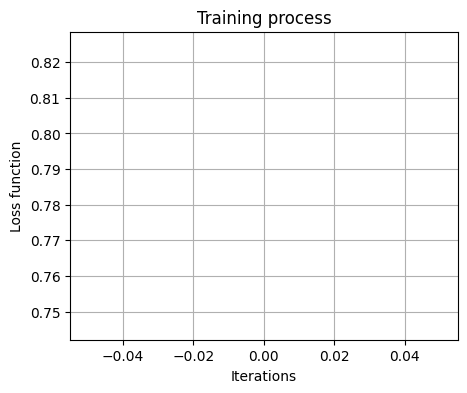

In [44]:
plt.figure(figsize=(5, 4))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function')

## Математика

![alt text](https://sun9-39.userapi.com/c850608/v850608777/47a4/fgZlI898IUU.jpg)
![alt text](https://sun9-41.userapi.com/c858216/v858216777/cc4f5/v3CPa-tnm80.jpg)
![alt text](https://sun9-67.userapi.com/c857632/v857632471/f6e95/H0dsmWsUInc.jpg)
![alt text](https://sun9-71.userapi.com/c858120/v858120274/10d0ef/hdKO-3Syk3g.jpg)



А теперь ваша очередь, нужно написать двуслоный персептрон, согласно коду и выкладкам выше

In [105]:
from os.path import samefile
### КОД СЮДА ###

learning_rate = 0.01  #если поставить 0.1, график лоссов получается получается посимпатичнее, но я решила так оставить
epochs = 3

batch_size = 128
n_feat = 784
inner_feat = 500

w1 = np.random.rand(n_feat, inner_feat)*0.01 # 784x500
b1 = np.zeros(1)
w2 = np.random.rand(inner_feat, 1)*0.01 # 500x1
b2 = np.zeros(1)

losses = []
my_predicted = []
my_true_labels = []

for n_epoch in range(epochs):

    print(f'Epoch: {n_epoch + 1}', losses)

    for x, y in train_loader:

        x = x.view(x.shape[0], -1).numpy() #приводим матрицу признаков к размерности 128x784 (b_s X n_feat)
        y = np.expand_dims(y.numpy(), 1) #приводим матрицу лэйблов к размерности 128x1

        z1 = (x @ w1) + b1 # 128x500 (b_s X inner_feat)
        a1 = 1 / (1 + np.exp(-z1)) # 128x500 (b_s X inner_feat)
        z2 = (a1 @ w2) + b2 # 128x1 (b_s X 1)
        a2 = 1 / (1 + np.exp(-z2)) # 128x1 (b_s X 1)

        bce = (-np.sum(np.multiply(y, np.log(a2)) + np.multiply((1-y), np.log(1-a2)))) / batch_size
        losses.append(bce)
        my_predicted.extend(a2)
        my_true_labels.extend(y)

        # backward
        same = a2 - y

        dldw2 = a1.T.dot(same) / batch_size # 500x1
        dldb2 = np.ones(batch_size).dot(same) / batch_size # 1x

        da1dz1 = np.ones((batch_size, inner_feat)) - ((np.exp(z1) - np.exp(-z1)) / (np.exp(z1) + np.exp(-z1))**2)
        new_same = np.multiply(same, np.multiply(w2.T, da1dz1)) # 128x500

        dldw1 = x.T @ new_same
        dldb1 = np.ones((batch_size, batch_size)) @ new_same

        # gradient descent
        w2 = w2 - learning_rate * dldw2
        b2 = b2 - learning_rate * dldb2
        w1 = w1 - learning_rate * dldw1
        b1 = b1 - learning_rate * dldb1

Epoch: 1 []
Epoch: 2 [0.9271131389275958, 0.6696196121230318, 0.6501813248515422, 0.616534017541807, 0.6001040118095982, 0.5507063870330595, 0.5034091413432102, 0.47633380916202595, 0.4198649648967423, 0.40780647186396324, 0.3852401226100226, 0.36023094848398385, 0.3300490317719885, 0.3382704664520908, 0.2951189585363538, 0.26962993854053285, 0.25017782473989497, 0.23802367325304108, 0.24929045754822649, 0.22976825951231666, 0.18464033780293573, 0.1897411485448298, 0.1577747578421669, 0.2004183549555973, 0.16369158676821807, 0.17634462681421315, 0.15807292667652587, 0.18785446862798627, 0.19458110447001986, 0.14909931600697096, 0.16650456760402482, 0.18041516602819643, 0.0976946285142404, 0.1942169901673929, 0.09153562682547878, 0.15790811965966128, 0.14111159732642042, 0.08969391617931918, 0.1250851377886038, 0.09342670570642755, 0.15126553823095423, 0.08606937053633862, 0.12732324012052582, 0.08917555602086456, 0.08474609311105431, 0.12348236747349771, 0.11780584997218976, 0.14225952

## Подсказки по размерностям

### Forward

- z1 - первое линейное преобразование - (BATCH_SIZE, INNER_FEATURES)
- a1 - Применение нелинейности - (BATCH_SIZE, INNER_FEATURES)
- z2 - второе нелинейное преобразование - (BATCH_SIZE, 1)
- pred or A2- сигмоида - (BATCH_SIZE, 1)
- loss - функция потерь - скаляр

### Backward

- d_BCE/d_pred - градиент функции потерь по pred - (BATCH_SIZE, 1)
- d_pred/dz2 - градиент сигмоиды по z2 - (BATCH_SIZE, 1)
- dz2/da1 - градиент линейного преобразования по a1 - (BATCH_SIZE, INNER_FEATURES)
- dz2/dw2 - градиент линейного преобразования по w2 - (INNER_FEATURES, 1)
- dz2/db2 - градиент линейного преобразования по b2 - (1,)
- da1/dz1 - градиент нелинейной функции по z1 - (BATCH_SIZE, INNER_FEATURES)
- dz1/dw1 - градиент линейного преобразования по w1 - (IN_FEATURES, INNER_FEATURES)
- dz1/db1 - градиент линейного преобразования по b1 - (INNER_FEATURES,)

и график нарисуйте

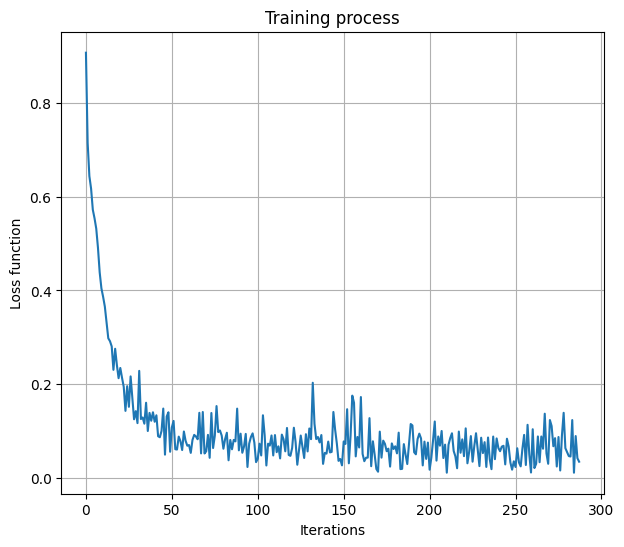

In [68]:
plt.figure(figsize=(7, 6))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function');

# Тестирование

А как это тестировать? Да, очень просто нужно просто выполнять форвард без бэкворда, то есть последовательно применять преобразования с обученными весами

In [69]:
losses_test = []
predicted = []
true_lbls = []

for x, y in test_loader:

  x = x.view(x.shape[0], -1).numpy()
  y = np.expand_dims(y.numpy(), 1)

  h1 = x.dot(w1) + b1 #переход в одномерное пространство
  p = 1/(1+np.exp(-h1)) #преобразование в "вероятности"

  bce = (-np.sum(np.multiply(np.log(p), y) + np.multiply((1 - y), np.log(1 - p)))) / batch_size
  #расчет энтропии с усреднением по размеру бача

  losses_test.append(bce)
  predicted.extend(p)
  true_lbls.extend(y)

<ipython-input-69-3856c042f1b2>:13: RuntimeWarning: divide by zero encountered in log
  bce = (-np.sum(np.multiply(np.log(p), y) + np.multiply((1 - y), np.log(1 - p)))) / batch_size


Проверим, что для каждого семпла у нас есть предсказание

In [70]:
print(len(predicted), len(true_lbls))

1920 1920


Теперь применим стандартную Ф меру и оценим нашу модель

In [108]:
from sklearn.metrics import f1_score
pred = np.array([round(i[0]) for i in predicted])
# У нас были вероятности а нужны классы поэтому просто округлим каждое значени и получим лейблы
t_lbls = np.array(true_lbls).squeeze() #снимем лишнюю размерность
f1 = f1_score(pred, t_lbls, average='weighted')
print('F1 score is equal to: {0:0.02f}'.format(f1))

F1 score is equal to: 0.97


Сделайте тоже самое для своей модели...

In [109]:
print(len(my_predicted), len(my_true_labels))

36864 36864


In [110]:
my_pred = np.array([round(i[0]) for i in my_predicted])
true_labels = np.array(my_true_labels).squeeze()
my_f1 = f1_score(my_pred, true_labels, average='weighted')
print('F1 score is equal to: {0:0.02f}'.format(my_f1))

F1 score is equal to: 0.97



# Немного торча

In [73]:
import torch

### Мы можем определить нашу модель как последовательность уже существующих слоев, как в керасе

In [74]:
model = torch.nn.Sequential()

model.add_module(name='linear_1', module=torch.nn.Linear(in_features=784, out_features=256))
model.add_module(name='relu', module=torch.nn.ReLU())
model.add_module(name='linear_2', module=torch.nn.Linear(in_features=256, out_features=1))
model.add_module(name='sigmoid', module=torch.nn.Sigmoid())

model

Sequential(
  (linear_1): Linear(in_features=784, out_features=256, bias=True)
  (relu): ReLU()
  (linear_2): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

### Либо так

In [75]:
model = torch.nn.Sequential(
    torch.nn.Linear(in_features=784, out_features=256),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=256, out_features=1),
    torch.nn.Sigmoid()
)

model

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=1, bias=True)
  (3): Sigmoid()
)

## А вот для чего нужно было писать в домашке классы
## Для определения своих моделей/слоев/чего вам захочется нам нужно сделать такую структуру

In [76]:
# наследуемся от класса torch.nn.Module
class MLP(torch.nn.Module):

    # определяем метод __init__
    # он нужен для того, чтобы мы могли определить нужные нам слои, веса, сохраняемые операции
    #
    # передаем ссылку на самого себя первым параметром
    #
    # определяем любые другие передаваемые аргументы
    # могут быть чем угодно: числа, словари, другие слои, другие модели и вообще все что угодно
    #
    def __init__(self, in_features, inner_features, out_features):

        # Главная задача этого метода - возможность использования в классе потомке, методов класса-родителя
        # Вызываем __init__ родителя - torch.nn.Module
        super().__init__()

        # определяем слои и все что захотим сохранять/использовать
        self.linear_1 = torch.nn.Linear(in_features=in_features, out_features=inner_features)
        self.non_linear_function = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(in_features=inner_features, out_features=out_features)
        self.sigmoid = torch.nn.Sigmoid()

    # нам нужно обязательно реализовать метод forward
    # это то, что нашей модели нужно делать, как оперировать с входными данными, как рассчитывать
    # метод backward нам не нужно реализовывать, потому что в торче есть автоматическое дифференцирование
    # главное, чтобы наши операции были дифференцируемы
    # некоторые подробности можете узнать здесь:
    # https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py
    # также список доступных дифференцируемых операций можете посмотреть здесь:
    # https://pytorch.org/docs/stable/tensors.html
    def forward(self, x):

        # наша привычная схема
        x = self.linear_1(x)
        x = self.non_linear_function(x)
        x = self.linear_2(x)
        x = self.sigmoid(x)

        return x

    # мы также можем реализовать любые другие полезные нам методы внутри класса

In [77]:
# определяем нашу модель
model = MLP(in_features=784, inner_features=256, out_features=1)

In [78]:
model

MLP(
  (linear_1): Linear(in_features=784, out_features=256, bias=True)
  (non_linear_function): ReLU()
  (linear_2): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [79]:
# можем посмотреть веса
model.linear_1.weight.shape

torch.Size([256, 784])

In [80]:
# еще нам нужно задать функцию потерь
criterion = torch.nn.BCELoss()

In [81]:
# и оптимизатор, куда нужно передать параметры модели
# параметры модели можно взять методом класса .parameters()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

In [82]:
# можем посмотреть на параметры нашей модели
params = list(model.parameters())
params

[Parameter containing:
 tensor([[ 0.0325, -0.0056,  0.0251,  ..., -0.0217, -0.0236,  0.0147],
         [ 0.0097,  0.0011, -0.0045,  ..., -0.0211, -0.0223, -0.0169],
         [ 0.0089, -0.0069, -0.0010,  ...,  0.0331, -0.0096, -0.0282],
         ...,
         [ 0.0046, -0.0067,  0.0186,  ..., -0.0309,  0.0019, -0.0046],
         [-0.0029, -0.0175, -0.0126,  ...,  0.0127, -0.0185,  0.0332],
         [-0.0091,  0.0250,  0.0103,  ...,  0.0075, -0.0036,  0.0064]],
        requires_grad=True),
 Parameter containing:
 tensor([ 1.9351e-02,  2.7403e-02,  1.1500e-02, -1.4561e-02, -1.9556e-02,
          8.5957e-03, -2.0460e-02,  1.8703e-02,  2.4943e-02, -3.6938e-03,
          2.5246e-02, -7.1322e-03, -1.2907e-02, -1.9327e-03,  2.0783e-02,
         -7.8466e-03, -2.1991e-02, -1.7805e-02, -1.3393e-04, -9.3420e-04,
          2.1264e-02,  3.3799e-02, -2.3221e-02,  2.1688e-03,  1.8485e-02,
          4.2495e-03, -2.9169e-03, -3.5215e-02,  2.6631e-02, -7.2890e-03,
          7.3844e-03, -9.6665e-03, -2.36

# Обучим нашу модель

In [83]:
# давайте сохранять значения нашей функции потерь каждую итерацию обучения
losses = []

# эта штука все еще отдает нам батчи данных
# мы поговорим про нее позже
for x, y in train_loader:

    x = x.view(x.shape[0], -1)
    y = y.unsqueeze(1).float()

    # обновим наши градиенты
    # будем делать это каждую итерацию обучения
    # потому что торч сохраняет в себе все градиенты пока не удалите таким образом рассчитанные градиенты
    #
    # НЕОБЯЗАТЕЛЬНЫЕ ДЕТАЛИ
    # функция сохранения градиентов нужна для аккамуляции градиентов
    # например, когда нам не хватает памяти на большой батч
    # мы можем несколько раз прогнать forward на разных батчах
    # наши градиенты будут сохраняться
    # и только потом обновить через несколько итераций forward обновить наши веса
    # таким образом у нас получается больше батч
    #
    optimizer.zero_grad()

    #
    # предсказание нашей модели
    # здесь торч сам сохраняет необходимую информацию
    # чтобы понять эту логику у нас как раз и была часть домашки про собственные классы
    #
    # торч строит динамический граф вычислений
    # то есть строит граф по тем операциям, которые вы определили в методе forward
    #
    # то есть торч понимает, что вы сначала применили линейное преобразование
    # знает, где лежат веса для этого линейного преобразования
    # знает, что вы затем применили релу
    # затем опять линейное преобразование
    # затем сигмоиду
    # и вот таким образом торч выстроил граф
    # который нужен будет для backpropogation
    #
    pred = model(x)

    #
    # рассчитываем функцию потерь, добавляя в наш граф вычислений этот узел
    #
    loss = criterion(pred, y.float())

    #
    # вызываем метод backward() от нашей функции потерь (это крайний узел нашего графа вычислений)
    # этот метод проходит от конца графа в начало, вычисляя необходимые градиенты
    # передаем градиенты на следующие узлы
    # для весов сохраняет
    #
    # то есть это почти то же самое, что мы делали в домашке с классами
    #
    loss.backward()

    #
    # теперь мы знаем необходимые градиенты и можем обновить веса с помощью градиентного спуска
    #
    optimizer.step()

    #
    # сохраним текущее значение функции потерь, чтобы потом могли посмотреть на график
    # очень важный момент: нам нужно отсоединить значение нашей фунции потерь от графа вычислений
    # чтобы граф не строился дальше на каждой итерации обучения
    # так мы рано или поздно переполним память
    # поэтому вызываем этот метод
    # работает для скаляров
    #
    # для тензоров работает метод .tolist()
    #
    current_loss_value = loss.item()
    losses.append(loss.item())

In [84]:
# Одна эпоха прошла

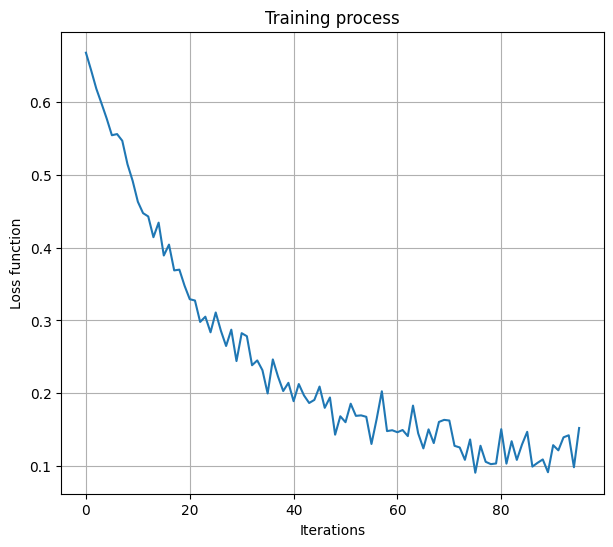

In [87]:
plt.figure(figsize=(7, 6))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function');

# Теперь мы можем что-то предсказать

In [88]:
for x, y in test_loader:

    x = x.view(x.shape[0], -1)
    y = y.unsqueeze(1).float()

    # чтобы не ходить по всему тестовому датасету, прекратим ходить после первой итерации
    break

In [89]:
x.shape

torch.Size([128, 784])

In [90]:
y.shape

torch.Size([128, 1])

In [91]:
# переходим в режим предсказания
#
# позже в курсе мы разберем зачем конкретно это нужно
#
# для искушенного нетерпеливого читателя: дропаут больше не дропаутит, батч норм больше не нормирует каждый батч
# а использует накопленную статистику при обучении и тд
#
model.eval()

MLP(
  (linear_1): Linear(in_features=784, out_features=256, bias=True)
  (non_linear_function): ReLU()
  (linear_2): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [92]:
# этот контект позволяет не сохранять необходимую информацию для рассчета градиентов
with torch.no_grad():

    pred = model(x)

In [93]:
pred.shape

torch.Size([128, 1])

In [94]:
# избавимся от единичной размерности
pred = pred.squeeze()
y = y.squeeze()

In [95]:
pred.shape

torch.Size([128])

In [96]:
# таким образом из торчовых тензоров мы можем сделать нумпаевские массивы
pred = pred.numpy()
y = y.numpy()

In [97]:
y

array([1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.,
       0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0.,
       1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1.,
       0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 1., 1., 0., 1., 0., 0., 1.], dtype=float32)

In [98]:
type(y)

numpy.ndarray

In [99]:
# бинаризируем наши предсказания
pred[pred > 0.5] = 1
pred[pred <= 0.5] = 0

In [100]:
# посчитаем метрику на батче
accuracy_score(y, pred)

0.9609375

In [101]:
# заново определим нашу модель и выучимся несколько эпох
# будут уже новые параметры
model = MLP(in_features=784, inner_features=256, out_features=1)

criterion = torch.nn.BCELoss()
# мы позже поговорим про этот оптимизационный алгоритм
optimizer = torch.optim.Adam(params=model.parameters())

# Типичный цикл обучения с кучей сохранений лоссов

In [102]:
epochs = 10
losses = []
# нужно для early stopping, то есть трекать лучший лосс на валидации
best_test_loss = 10.

for n_epoch in range(epochs):

    train_losses = []
    test_losses = []
    test_preds = []
    test_targets = []

    progress_bar = tqdm(total=len(train_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))

    for x, y in train_loader:

        x = x.view(x.shape[0], -1)
        y = y.unsqueeze(1).float()

        optimizer.zero_grad()

        pred = model(x)

        loss = criterion(pred, y.float())

        loss.backward()

        optimizer.step()

        train_losses.append(loss.item())
        losses.append(loss.item())

        progress_bar.set_postfix(train_loss = np.mean(losses[-100:]))

        progress_bar.update(x.shape[0])

    progress_bar.close()

    for x, y in test_loader:

        x = x.view(x.shape[0], -1)
        y = y.unsqueeze(1).float()

        with torch.no_grad():

            pred = model(x)

        test_preds.append(pred.numpy())
        test_targets.append(y.numpy())

        loss = criterion(pred, y)

        test_losses.append(loss.item())

    mean_test_loss = np.mean(test_losses)

    print('Losses: train - {:.3f}, test = {:.3f}'.format(np.mean(train_losses), mean_test_loss))

    test_preds = np.concatenate(test_preds)
    test_preds = test_preds.squeeze()
    test_targets = np.concatenate(test_targets).squeeze()

    test_preds[test_preds > 0.5] = 1
    test_preds[test_preds <= 0.5] = 0

    accurary = accuracy_score(test_targets, test_preds)

    print('Test: accuracy - {:.3f}'.format(accurary))

    # как раз early stopping
    # то есть: если наша функция потерь на валидационном датасете стала расти, то прекращаем обучение
    # рост фунции потерь на валидационном датасете говорит о переобучении
    # пожалуй, самый популярный метод валидации для нейронных сетей
    if mean_test_loss < best_test_loss:
        best_test_loss = mean_test_loss
    else:
        print('Early stopping')
        break

Epoch 1:  99%|█████████▉| 12288/12396 [00:04<00:00, 2463.46it/s, train_loss=0.0688]


Losses: train - 0.069, test = 0.065
Test: accuracy - 0.980


Epoch 2:  99%|█████████▉| 12288/12396 [00:06<00:00, 1780.73it/s, train_loss=0.0293]


Losses: train - 0.029, test = 0.032
Test: accuracy - 0.989


Epoch 3:  99%|█████████▉| 12288/12396 [00:03<00:00, 3660.70it/s, train_loss=0.0209]


Losses: train - 0.020, test = 0.028
Test: accuracy - 0.992


Epoch 4:  99%|█████████▉| 12288/12396 [00:03<00:00, 3602.16it/s, train_loss=0.0111]


Losses: train - 0.011, test = 0.026
Test: accuracy - 0.992


Epoch 5:  99%|█████████▉| 12288/12396 [00:04<00:00, 3031.45it/s, train_loss=0.00639]


Losses: train - 0.006, test = 0.024
Test: accuracy - 0.993


Epoch 6:  99%|█████████▉| 12288/12396 [00:03<00:00, 3686.44it/s, train_loss=0.00367]


Losses: train - 0.004, test = 0.021
Test: accuracy - 0.993


Epoch 7:  99%|█████████▉| 12288/12396 [00:03<00:00, 3724.26it/s, train_loss=0.00323]


Losses: train - 0.003, test = 0.022
Test: accuracy - 0.994
Early stopping


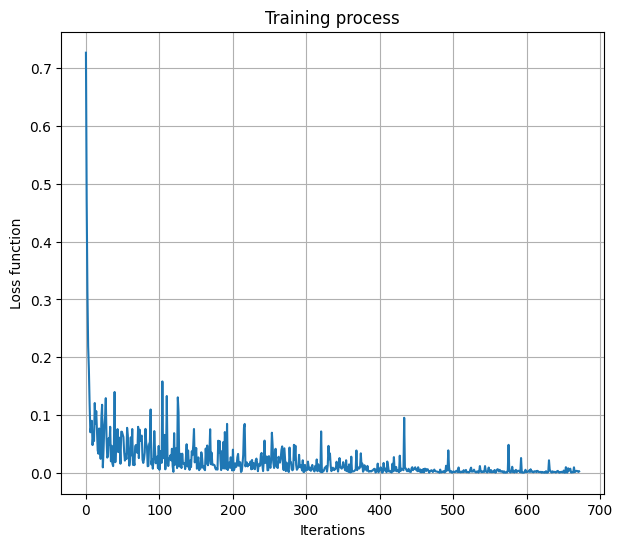

In [104]:
plt.figure(figsize=(7, 6))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function');